In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import GridSearchCV
style.use("ggplot")

def plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(train_rolling_loss,label="training")
    plt.plot(dev_rolling_loss,label="dev")
    plt.title("Rolling Loss",loc='center')
    plt.legend(loc=1)
    plt.subplot(222)
    plt.plot(train_rolling_acc,label="training")
    plt.plot(dev_rolling_acc,label="dev")
    plt.title("Rolling Accuracy",loc='center')
    plt.legend(loc=0)
    plt.show()

## 1. Process Data

In [48]:
## reading clean data
data = pd.read_csv('cleaned_6_Sep.csv')
data.head()
data.describe()
data.columns

Index(['Id', 'StageName', 'Status_Reason__c', 'RecordType.Name',
       'RICE_Supported__c', 'CreatedDate', 'CloseDate', 'Actual_Close_Date__c',
       'AccountId', 'Lead_Faculty__c', 'Lead_School__c',
       'Parent_Opportunity__c', 'RecordType.Name.1', 'Industry',
       'Industry_Sub_Type__c', 'Business_Type__c', 'Is_External__c',
       'ParentId', 'CloseYear', 'CloseMonth', 'CreatedYear', 'CreatedMonth',
       ' Time_length'],
      dtype='object')

In [49]:
## one-hot-encoding 11

a = pd.get_dummies(data["Status_Reason__c"], prefix='Status_Reason')
b = pd.get_dummies(data["RecordType.Name"], prefix='RecordType')
c = pd.get_dummies(data["RICE_Supported__c"], prefix='RICE_Supported')
d = pd.get_dummies(data["AccountId"], prefix='AccountId')
e = pd.get_dummies(data["Lead_Faculty__c"], prefix='Lead_Faculty')
e1 = pd.get_dummies(data["Lead_School__c"], prefix='Lead_School')
f = pd.get_dummies(data["RecordType.Name.1"], prefix='RecordType_ind')
g = pd.get_dummies(data["Industry"], prefix='Industry')
g1 = pd.get_dummies(data["Industry_Sub_Type__c"], prefix='Industry_Sub_Type')
h = pd.get_dummies(data["Business_Type__c"], prefix='Business_Type')
#i = pd.get_dummies(data["RecordType"], prefix='RecordType_mixed')
j = pd.get_dummies(data["Is_External__c"], prefix='Is_External')

org = data[["StageName","Actual_Close_Date__c","Parent_Opportunity__c","ParentId"]]

scale1 = data["CloseYear"].div(2050)
scale2 = data["CloseMonth"].div(12)
scale3 = data["CreatedYear"].div(2020)
scale4 = data["CreatedMonth"].div(12)
scale5 = data[" Time_length"].div(31)

df = pd.concat([org,scale1,scale2,scale3,scale4,scale5,a,b,c,d,e,e1,f,g,g1,h,j], axis=1, ignore_index=True)

In [6]:
org = data[["StageName","Parent_Opportunity__c","ParentId"]]

scale1 = data["CreatedDate"].div(2020)
scale2 = data["CreatedDate_month"].div(12)

df = pd.concat([org,scale1,scale2], axis=1, ignore_index=True)

In [50]:
df

,0,1,2,3,4,5,6,7,8,9,...,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272
0,0,1,0,0,0.985366,0.666667,0.999505,0.916667,0.032258,0,...,0,0,1,0,0,0,0,0,1,0
1,1,1,0,1,0.999512,1.000000,0.999010,0.750000,1.000000,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,1,0.985366,0.500000,0.999010,0.750000,0.064516,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,0,0,0.985366,0.500000,0.999505,0.166667,0.032258,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,1,0.985366,0.500000,0.998515,0.333333,0.096774,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5511,1,1,1,1,0.985366,1.000000,1.000000,0.583333,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
5512,1,1,0,0,0.985366,0.583333,1.000000,0.583333,0.000000,0,...,0,0,0,0,0,0,0,1,1,0
5513,1,1,0,0,0.985366,0.583333,1.000000,0.583333,0.000000,0,...,0,0,0,0,0,0,0,1,1,0
5514,1,1,0,0,0.985854,0.083333,1.000000,0.666667,0.032258,0,...,0,0,0,0,0,0,0,0,1,0


In [51]:
# split xy
dflist = df.values.tolist()
random.shuffle(dflist)
x = torch.Tensor([i[1:] for i in dflist])
y = torch.Tensor([i[1] for i in dflist])

In [52]:
# train/dev split
batch_size = 64

from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.33, random_state=42)

train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train,y_train)), batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_dev,y_dev)), batch_size=batch_size, shuffle=False)

## 2. Neural Network Model

In [71]:
class Net(torch.nn.Module):

    def __init__(self, n_features, n_classes):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(n_features,512)
        self.linear2 = torch.nn.Linear(512, 512)
        self.linear3 = torch.nn.Linear(512, 256)
        self.linear4 = torch.nn.Linear(256, 128)
        self.linear5 = torch.nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        out = F.sigmoid(x)
        return out

def test_net(test_loader, epoch, model, criterion):
    correct = 0
    total = 0
    test_loss = 0.
    test_acc = 0.
    
    for features, labels in test_loader:
        features = Variable(features)
        labels = Variable(labels)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        acc = torch.mean(torch.eq(torch.round(outputs), labels).float()).item()
        test_acc += acc
    
    return test_loss/len(test_loader), test_acc/len(test_loader)


def train_net(train_loader,dev_loader,lr_rate):
    train_rolling_loss = []
    dev_rolling_loss = []
    train_rolling_acc = []
    dev_rolling_acc = []
    
    #model = Net(int(x_train.shape[1]), 1) # n_features, n_classes
    #criterion = torch.nn.BCELoss() # binary cross entropy (MSE)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

    for epoch in tqdm(range(int(epochs))):
        train_loss = 0.
        train_acc = 0.
        
        for i, (features, labels) in enumerate(train_loader):
            features = Variable(features)
            labels = Variable(labels)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            acc = torch.mean(torch.eq(torch.round(outputs), labels).float()).item()
            train_acc += acc
            
        #print(train_acc, len(train_loader))
        
        train_rolling_acc.append(train_acc/len(train_loader))
        train_rolling_loss.append(train_loss/len(train_loader))

        ## calculating loss on dev set
        
        dev_loss,dev_acc = test_net(dev_loader, epoch, model, criterion)
        dev_rolling_loss.append(dev_loss)
        dev_rolling_acc.append(dev_acc)
        
        
    print("Train Accuracy: ",train_rolling_acc[-1],", Dev Accuracy: ",dev_rolling_acc[-1])
    print("Train Loss: ",train_rolling_loss[-1],", Dev Loss: ",dev_rolling_loss[-1])
    
    plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc)
    
    return train_rolling_acc[-1],dev_rolling_acc[-1]

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Train Accuracy:  1.0 , Dev Accuracy:  1.0
Train Loss:  0.005360566234836976 , Dev Loss:  0.004361861578092493


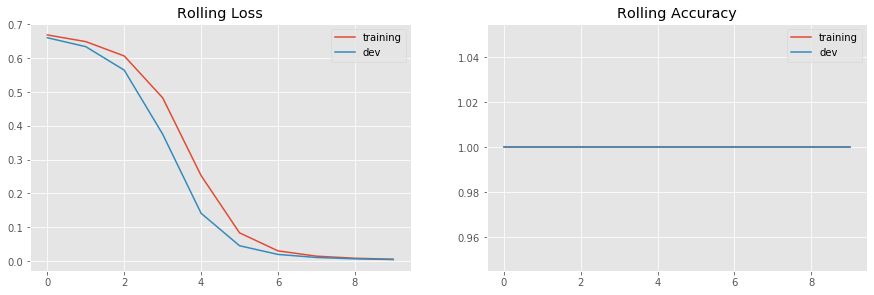

(1.0, 1.0)

In [72]:
model = Net(int(x_train.shape[1]), 1) # n_features, n_classes
criterion = torch.nn.BCELoss() # binary cross entropy (MSE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
train_net(train_loader,dev_loader,lr_rate)

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Train Accuracy:  1.0 , Dev Accuracy:  1.0
Train Loss:  0.007706076527635257 , Dev Loss:  0.006082861170429608


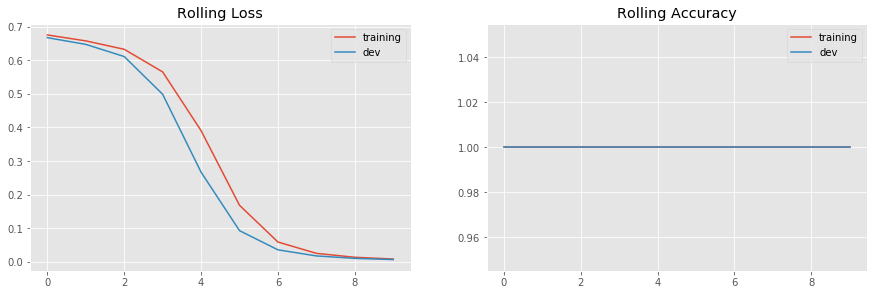

(1.0, 1.0)

In [66]:
#### RUN MODEL
epochs = 10
lr_rate = 0.00001

train_net(train_loader,dev_loader,lr_rate)

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Train Accuracy:  0.0 , Dev Accuracy:  0.0
Train Loss:  0.6931470686044449 , Dev Loss:  0.693147077642638


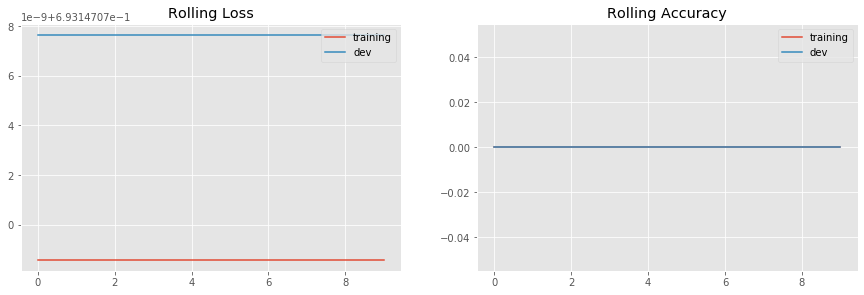

 20%|██        | 2/10 [00:04<00:18,  2.28s/it]


KeyboardInterrupt: 

In [63]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)
train_acc = []
dev_acc = []
for fold, (train_index, test_index) in enumerate(kfold.split(x, y)):
        ### Dividing data into folds
    x_train_fold = x[train_index]
    x_test_fold = x[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]

    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    test = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    train_accu, dev_accu = train_net(train_loader,dev_loader,lr_rate)
    dev_acc.append(dev_accu)
    train_acc.append(train_accu)

In [61]:
total_acc

[0.9008091520518064,
 0.8238593898713589,
 0.8238593898713589,
 0.9008091520518064,
 0.9008091520518064,
 0.9008091520518064,
 0.9008091520518064,
 0.9008091520518064,
 0.9008091520518064,
 0.9008091520518064]

In [62]:
sum(total_acc)/10

0.8854191996157169